In [1]:
from siphon.catalog import TDSCatalog
top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
for ref in top_cat.catalog_refs:
    print(ref)

Forecast Model Data
Forecast Products and Analyses
Observation Data
Radar Data
Satellite Data
Unidata case studies


In [2]:
ref = top_cat.catalog_refs['Forecast Model Data']
new_cat = ref.follow()
list(new_cat.catalog_refs)

['GEFS Members - Analysis',
 'GEFS Members - Forecasts',
 'GEFS Derived Forecast Products',
 'GFS Quarter Degree Analysis',
 'GFS Quarter Degree Forecast',
 'GFS Half Degree Analysis',
 'GFS Half Degree Forecast',
 'GFS One Degree Analysis',
 'GFS One Degree Forecast',
 'GFS Global 1.0 Degree (NOAAPORT)',
 'GFS Pacific 20km',
 'GFS Puerto Rico Quarter Degree',
 'GFS CONUS 80km',
 'GFS CONUS 20km',
 'GFS Alaska 20km',
 'GSD HRRR CONUS 3km wrfprs',
 'GSD HRRR CONUS 3km surface',
 'NCEP HRRR CONUS 2.5km Analysis',
 'NCEP HRRR CONUS 2.5km',
 'NAM Alaska 11km',
 'NAM Alaska 45km from NOAAPORT',
 'NAM Alaska 45km from CONDUIT',
 'NAM Alaska 95km',
 'NAM CONUS 12km from NOAAPORT',
 'NAM CONUS 12km from CONDUIT',
 'NAM CONUS 20km',
 'NAM CONUS 40km',
 'NAM CONUS 80km',
 'NAM Polar 90km',
 'NAM Fireweather Nested',
 'Rapid Refresh CONUS 13km',
 'Rapid Refresh CONUS 20km',
 'Rapid Refresh CONUS 40km',
 'SREF CONUS 40km Ensemble Derived Products',
 'SREF CONUS 40km Ensemble Derived Products (Bias

In [13]:
%matplotlib inline
import os, subprocess
from siphon.catalog import TDSCatalog
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from netCDF4 import num2date
import numpy as np
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj
import pyproj
import rasterio
from rasterio.transform import from_origin


# Define bounding box
North = 30.25
South = 29.75
West = -96
East = -95.25
LeadTime = 2 # in days

res = 1000. #resampled resolution in meter UTM

save_dir = 'Forecast_GFS/'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
        
# use pyproj to convert lats lons to UTM
GRIB2_proj = Proj("+proj=longlat +ellps=WGS84 +pm=-360 +datum=WGS84 +no_defs") #put pm=-360 to indicate GRIB2 projection
Projected = Proj(init="EPSG:26914") #26914 Cypress UTM 14N
#Parameter = 'Total_precipitation_surface_Mixed_intervals_Accumulation'
Parameter = 'Precipitable_water_entire_atmosphere_single_layer'

def Plot_Parameter(Precipitation_vals, lon_2d, lat_2d):

    # Combine 1D latitude and longitudes into a 2D grid of locations
    fig = plt.figure(figsize=(10, 9))

    # Add the map and set the extent
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([East, West, North, South])

    # Contour Parameter at each lat/long
    cf = ax.contourf(lon_2d, lat_2d, Precipitation_vals, 200, transform=ccrs.PlateCarree(), zorder=0, cmap='coolwarm')

    # Plot a colorbar to show Parameter and reduce the size of it
    plt.colorbar(cf, ax=ax, fraction=0.02)

    # Make a title with the time value
    ax.set_title(u'Precipitation Forecast (mm) for {0:%d %B %Y %H:%MZ}'.format(time_val), fontsize=20)

    # Plot markers for each lat/long to show grid points for 0.25 deg GFS
    ax.plot(lon_2d.flatten(), lat_2d.flatten(), marker='o', color='black', markersize=2, alpha=0.3, transform=ccrs.Geodetic(), zorder=2, linestyle='none')

    # Add state boundaries to plot
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=12)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    plt.close()
    
    # save rather than show
#     plt.saveas()


# Get the dataset handle
top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
models_cat = top_cat.catalog_refs[0].follow()
gfs_cat = models_cat.catalog_refs['GFS Quarter Degree Forecast'].follow()
ncss = gfs_cat.latest.subset()
now = datetime.utcnow()


# Download a subset in box using NCSS
queryBox = ncss.query().lonlat_box(east=East, west=West, south=South, north=North)
queryBox.time_range(now, now + timedelta(days=LeadTime)).accept('netcdf4')
queryBox.variables(Parameter)
data = ncss.get_data(queryBox)
Precipitation_var = data.variables[Parameter] # pull time variable out of the coordinates attribute on Precipitation
time_name = Precipitation_var.coordinates.split()[0]
time_var = data.variables[time_name]
lat_var = data.variables['lat']
lon_var = data.variables['lon']
lat_vals = lat_var[:].squeeze()
lon_vals = lon_var[:].squeeze()


#convert coordinate
x,y = np.meshgrid(lon_vals, lat_vals)
UTMx, UTMy = pyproj.transform(GRIB2_proj, Projected, x.flatten(), y.flatten())
UTMx_grid = np.reshape(UTMx,(x.shape))
UTMy_grid = np.reshape(UTMy,(y.shape))
xmin, xmax, ymin, ymax = [UTMx.min(), UTMx.max(), UTMy.min(), UTMy.max()]
UTMx_res = np.arange(xmin, xmax, res)
UTMy_res = np.arange(ymin, ymax, res)
grid_x_res, grid_y_res = np.meshgrid(UTMx_res, UTMy_res)
nrows_res, ncols_res = np.shape(grid_x_res)



for timeId in range(0, np.shape(time_var)[0], 2):
    
    # Get the actual data values and remove any size 1 dimensions
    Precipitation_vals = Precipitation_var[timeId].squeeze()
    
    # Convert the number of hours since the reference time to an actual date, check the array index
    time_val = num2date(time_var[timeId].squeeze(), time_var.units)
    print(num2date(time_var[timeId].squeeze(), time_var.units))
    
    #convert date to string
    filenameASC = save_dir + 'gfs.0p25.' + time_val.strftime("%Y%m%d%H") + '.asc'
    
    #resample raster
    Precipitation_res = interpolate.griddata((UTMx_grid.flatten(), UTMy_grid.flatten()), Precipitation_vals.flatten(), (grid_x_res, grid_y_res) , method='cubic')
    Precipitation_res[np.isnan(Precipitation_res)]=-9999
    #save resampled raster to ascii
    transform = from_origin(grid_x_res.min(), grid_y_res.max(), res, res)
    new_dataset = rasterio.open(filenameASC, 'w', nodata = -9999, driver='AAIGrid', decimal_precision=1,
                                height = nrows_res, width = ncols_res,
                                count=1, dtype=str(Precipitation_res.dtype),
                                transform=transform,
                                crs=Projected.srs)
    new_dataset.write(Precipitation_res, 1)
    new_dataset.close()

2019-08-12 12:00:00
2019-08-12 18:00:00
2019-08-13 00:00:00
2019-08-13 06:00:00
2019-08-13 12:00:00
2019-08-13 18:00:00
2019-08-14 00:00:00
2019-08-14 06:00:00


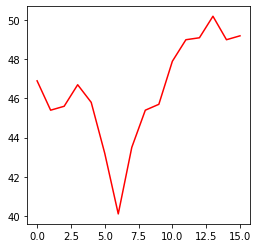

In [14]:
# Download a subset using NCSS
querypoint = ncss.query().lonlat_point(lon=-96, lat=29.75)
querypoint.time_range(now, now + timedelta(days=LeadTime)).accept('netcdf4')
querypoint.variables(Parameter)
data_point = ncss.get_data(querypoint)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
Precip_Point = data_point.variables[Parameter][:]
ax.plot(Precip_Point, color='r')

Convert ASC files to HEC-DSS

In [25]:
# convert to DSS
import re
import glob 
import platform
from datetime import datetime, timedelta

# Local variables:
# my_path = os.path.abspath(os.path.dirname(__file__))
# inDir = os.path.join(my_path, "..\Forecast_GFS")
# openBATfile = my_path  + "\ASCIIToDSS.bat"

# Local variables:
#inDir = 'Precipitation_Mongolia/ASC_2000_Dis/'
openBATfile = save_dir + 'ASCIIToDSS.bat'

# for generating asc2dss strings
text_1 = "asc2dssGrid INPUT="
text_2 = " DSS=GFS.dss PATH=/UTM14/Cypress/Precip/"
text_3 = "/"
text_4 = "/PROJECTED/ GRIDTYPE=UTM ZONE=14N DUNITS=mm DTYPE=PER-CUM" 

# Open and Write to file1  
file1 = open(openBATfile,"w")

# date = [date for file in glob.glob(inDir + '*.asc') for date in re.findall("(\d{10})", file)]
date = [date for file in glob.glob(save_dir + '*.asc') for date in re.findall("(\d{10})", file)]
date.sort(key = lambda date: datetime.strptime(date, "%Y%m%d%H")) 
delt = datetime.strptime(date[1], "%Y%m%d%H") - datetime.strptime(date[0], "%Y%m%d%H")
# AscFiles = glob.glob(inDir + '*.asc')
AscFiles = glob.glob(save_dir + '*.asc')

for index in range(0, len(date)):

    namefile = 'gfs.0p25.' + date[index] + '.asc'
    objDate = datetime.strptime(date[index], '%Y%m%d%H')

    if (objDate.hour==0): 
        objDate0 = objDate - delt #timedelta(hours=1)
        objDate = objDate - delt #timedelta(days=1)
        converted_date = datetime.strftime(objDate,'%d%b%Y:2400') #HEC-DSS only accept 24:00 format!
    else:
        converted_date = datetime.strftime(objDate,'%d%b%Y:%H%M')
        objDate0 = objDate - delt#timedelta(hours=1)
    
    converted_date0 = datetime.strftime(objDate0,'%d%b%Y:%H%M')

    full_text = text_1 + namefile + text_2 + converted_date0 + text_3 + converted_date + text_4
    file1.write(full_text + "\n")
    
file1.close() #to close file   

In [16]:
openBATfile

'Forecast_GFS/ASCIIToDSS.bat'

execute asc2dssGrid.exe

In [24]:
import subprocess
subprocess.check_call(r'C:\temp\Flood_Forecasting\Forecast_GFS\ASCIIToDSS.bat')

CalledProcessError: Command 'C:\temp\Flood_Forecasting\Forecast_GFS\ASCIIToDSS.bat' returned non-zero exit status 1.